In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\totog\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Chargement des données
df = pd.read_csv("Data/Etude sur les Français et l_Information/les-francais-et-l-information-propre.csv")

# Chargement des questions
with open("Data/Etude sur les Français et l_Information/questionnaire.json", "r") as f:
    questionnaire = json.load(f)


C:\Users\totog\AppData\Local\Temp\ipykernel_14072\3238581139.py:2: DtypeWarning: Columns (16,20,104,105,111,112,113,120,121,128,129,136,137,145,152,153,234,264,265,279,280,281,282,296,305,316,317,318,330,342,343,344) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/Etude sur les Français et l_Information/les-francais-et-l-information-propre.csv")


## Premier modèle: Prédire le vote avec les chaines TV.

On refait un peu de nettoyage des données, suppression des NaN est one-hot encoding pour les catégories de la variable à prédire.

In [3]:
# Variables prédictives
liste_col = [col for col in df.columns if col.startswith("SOURCES1DR_B4_R")]
liste_col += [col for col in df.columns if col.startswith("SOURCES1ER_B4_R")]
X_brut = df[liste_col]

# Variable à prédire 
y = df["PP3_R"]

# Supression des nan
print("Avant suppression des nan: ")
print("Taille de X: ", X_brut.shape)
print("Taille de y: ", y.shape)

condition_X = X_brut.isna().all(axis=1)
condition_y_1 = y.isna() | (y == "Je ne suis pas inscrit sur les listes électorales")
condition_y_2 = (y == "Je ne suis pas inscrit·e sur les listes électorales") | (y=="Non réponse")

indices_nan = df.index[condition_X | condition_y_1 | condition_y_2]
X_brut = X_brut.drop(index = indices_nan)
y = y.drop(index = indices_nan)

print("\nAprès suppression des nan: ")
print("Taille de X: ", X_brut.shape)
print("Taille de y: ", y.shape)

# Liste des chaîne de TV
liste_valeurs_avec_nan= pd.unique(X_brut.values.ravel())
liste_valeurs = [val for val in liste_valeurs_avec_nan if not pd.isna(val)]

# Initialiser un DataFrame avec une colonne par chaîne et des zéros
X = pd.DataFrame(0, index=X_brut.index, columns=liste_valeurs)

# Remplir le DataFrame final
for i, row in X_brut.iterrows():
    # Extraire les réponses non NaN de la ligne courante
    reponses = row.dropna().unique().tolist()
    # Mettre 1 dans les colonnes correspondantes aux réponses
    X.loc[i, reponses] = 1

# Vérification de la cohérence des données
"""condition = X.apply(
    lambda row: (row['Rien de tout cela'] == 0) or (row['Rien de tout cela'] == 1 and (row.drop('Rien de tout cela') == 0).all()),
    axis=1
)
if not condition.all():
    print("\nDONNÉES INCOHÉRENTES")"""
    
# Suppression de la colonne donnant une information redondante
"""else:"""
X = X.drop(columns=['Rien de tout cela'])

X

Avant suppression des nan: 
Taille de X:  (3346, 22)
Taille de y:  (3346,)

Après suppression des nan: 
Taille de X:  (2688, 22)
Taille de y:  (2688,)


,France 2,Arte,Non cité,Une autre chaîne TV généraliste,TF1,France 3,BFM TV,CNews,M6,C8,TMC,France 5,France24,LCI,Franceinfo la chaîne de TV,Canal+,RMC Story,"Chaînes d'information internationale (Al Jazeera, CNN, BBC etc..)",Une autre chaîne d’information internationale,Une chaîne de TV locale
2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0
3341,0,0,0,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0
3342,1,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0,0,0,0,1
3344,1,0,0,0,1,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0


Voici quelques statistiques descriptives sur les données

In [4]:
print(X.apply(pd.Series.value_counts))  # Comptage des valeurs (0 et 1) pour chaque colonne

   France 2  Arte  Non cité  Une autre chaîne TV généraliste   TF1  France 3  \
0      1616  1926      2639                             2582  1272      1813   
1      1072   762        49                              106  1416       875   

   BFM TV  CNews    M6    C8   TMC  France 5  France24   LCI  \
0    1629   1921  1529  2209  2255      2081      2318  2009   
1    1059    767  1159   479   433       607       370   679   

   Franceinfo la chaîne de TV  Canal+  RMC Story  \
0                        2162    2329       2335   
1                         526     359        353   

   Chaînes d'information internationale (Al Jazeera, CNN, BBC etc..)  \
0                                               2597                   
1                                                 91                   

   Une autre chaîne d’information internationale  Une chaîne de TV locale  
0                                           2648                     2646  
1                                       

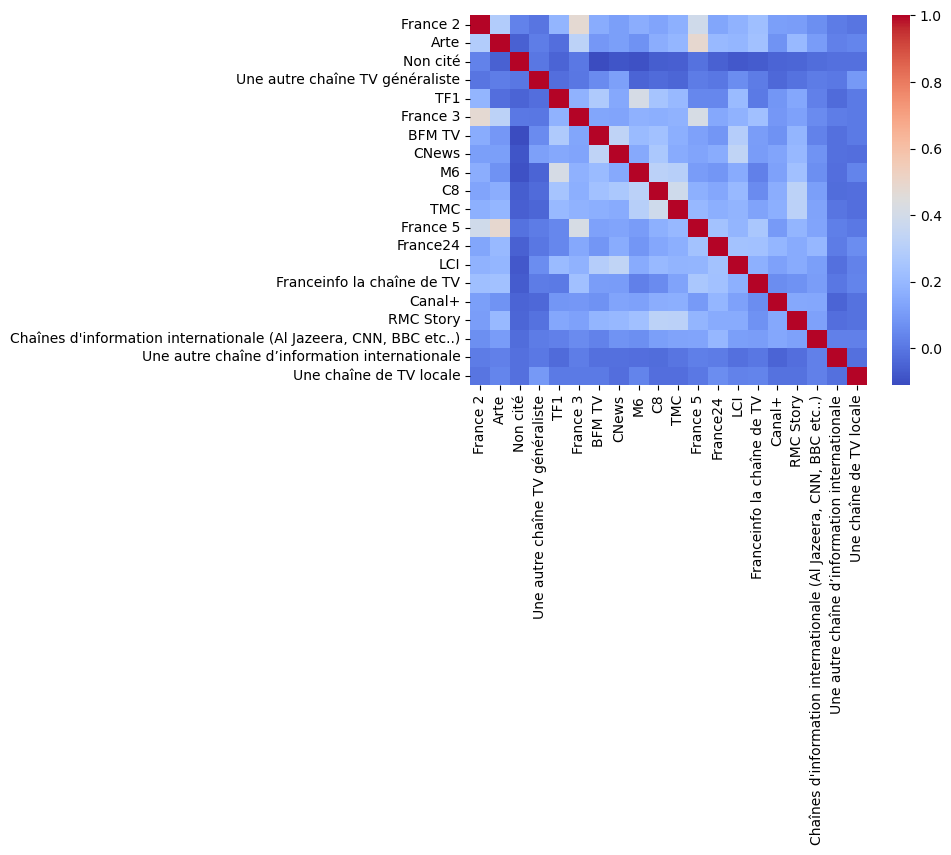

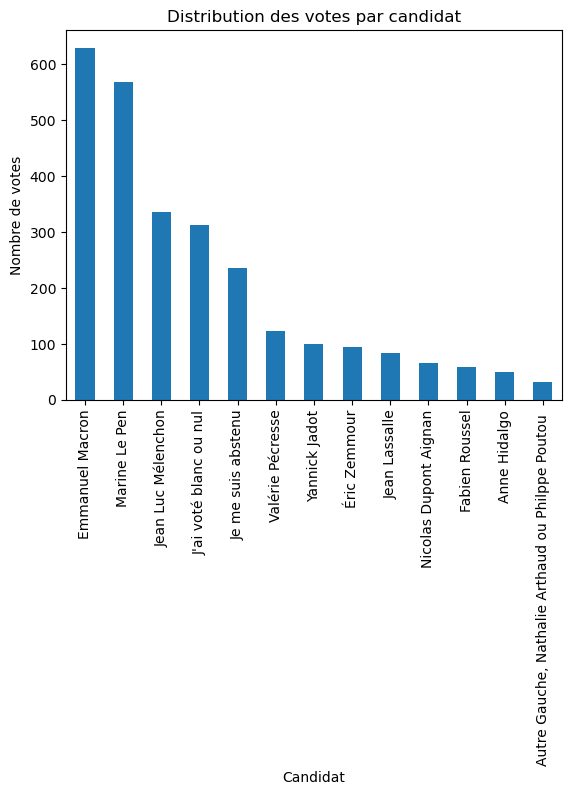

In [6]:
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.show()

y.value_counts().plot(kind='bar')
plt.xlabel('Candidat')
plt.ylabel('Nombre de votes')
plt.title('Distribution des votes par candidat')
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Encodage des classes de y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Division des données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Définition de la grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Création du modèle XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Recherche des meilleurs hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Entraînement
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Modèle optimal
best_xgb = grid_search.best_estimator_

# Prédictions
y_pred = best_xgb.predict(X_test)

# Décodage des prédictions
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Rapport de classification
print("Rapport de classification :\n", classification_report(y_test_decoded, y_pred_decoded))

# Matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test_decoded, y_pred_decoded))

# Accuracy
print("Précision (accuracy) :", accuracy_score(y_test_decoded, y_pred_decoded))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\totog\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs hyperparamètres : {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Rapport de classification :
                                                    precision    recall  f1-score   support

                                     Anne Hidalgo       0.00      0.00      0.00        10
Autre Gauche, Nathalie Arthaud ou Philppe Poutou        0.00      0.00      0.00         6
                                  Emmanuel Macron       0.30      0.58      0.40       126
                                   Fabien Roussel       0.00      0.00      0.00        12
                           J'ai voté blanc ou nul       0.40      0.03      0.06        63
                               Je me suis abstenu       0.00      0.00      0.00        47
                                    Jean Lassalle       0.00      0.00      0.00        17
                               Jean Luc Mélenchon       0.35      0.13      0.19        67
         

c:\Users\totog\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\totog\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\totog\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Deuxième modèle: Prédiction du penchant politique en fonction des chaines de TV

In [ ]:
# Variables prédictives
liste_col = [col for col in df.columns if col.startswith("SOURCES1DR_B4_R")]
liste_col += [col for col in df.columns if col.startswith("SOURCES1ER_B4_R")]
X_brut = df[liste_col]

# Variable à prédire 
y = df["PP3_R"]

# Supression des nan
print("Avant suppression des nan: ")
print("Taille de X: ", X_brut.shape)
print("Taille de y: ", y.shape)

condition_X = X_brut.isna().all(axis=1)
condition_y_1 = y.isna() | (y == "Je ne suis pas inscrit sur les listes électorales")
condition_y_2 = (y == "Je ne suis pas inscrit·e sur les listes électorales") | (y=="Non réponse")

indices_nan = df.index[condition_X | condition_y_1 | condition_y_2]
X_brut = X_brut.drop(index = indices_nan)
y = y.drop(index = indices_nan)

print("\nAprès suppression des nan: ")
print("Taille de X: ", X_brut.shape)
print("Taille de y: ", y.shape)

# Liste des chaîne de TV
liste_valeurs_avec_nan= pd.unique(X_brut.values.ravel())
liste_valeurs = [val for val in liste_valeurs_avec_nan if not pd.isna(val)]

# Initialiser un DataFrame avec une colonne par chaîne et des zéros
X = pd.DataFrame(0, index=X_brut.index, columns=liste_valeurs)

# Remplir le DataFrame final
for i, row in X_brut.iterrows():
    # Extraire les réponses non NaN de la ligne courante
    reponses = row.dropna().unique().tolist()
    # Mettre 1 dans les colonnes correspondantes aux réponses
    X.loc[i, reponses] = 1

# Vérification de la cohérence des données
"""condition = X.apply(
    lambda row: (row['Rien de tout cela'] == 0) or (row['Rien de tout cela'] == 1 and (row.drop('Rien de tout cela') == 0).all()),
    axis=1
)
if not condition.all():
    print("\nDONNÉES INCOHÉRENTES")"""
    
# Suppression de la colonne donnant une information redondante
"""else:"""
X = X.drop(columns=['Rien de tout cela'])

In [7]:
questionnaire

{'LEVEL_A': 'Records',
 'RECORDS': "Numéro d'enregistrement",
 'UUID': 'Identifiant du partcipant',
 'CIBLE': 'Cible',
 'SOURCE_BASE_R1': 'Source',
 'POIDS03': 'Poids',
 'RS1_R': 'Genre',
 'RS2C_RECODE_AG_R': 'Age',
 'RS3_R': 'Situation professionnelle',
 'RS4_R': 'Profession',
 'CSPIND_R': 'CSP',
 'RS5_R': "Niveau d'étude",
 'UDA9_R': 'Région en 9',
 'UDA5_R': 'Région en 5',
 'DPT_DOM': 'DOM',
 'CC_R': 'Taille agglo',
 'RS7_R': 'Nombre de personnes dans le foyer',
 'RS14_R': 'Revenu mensuel net du foyer',
 'ILLECTRO_R': "Dernière utilisation d'internet",
 'RS15_R': "Fréquence d'utilisation d'internet",
 'FREQ_INTERNET_R': "Fréquence d'utilisation d'internet (recode)",
 'RS16_R': 'Équipement média',
 'RS16_R_1': 'un poste de TV',
 'RS16_R_2': 'un poste de radio, une chaine hifi',
 'RS16_R_3': 'un autoradio',
 'RS16_R_4': 'un smartphone',
 'RS16_R_5': 'un ordinateur fixe',
 'RS16_R_6': 'un ordianteur portable',
 'RS16_R_7': 'une tablette tactile',
 'RS16_R_8': 'la google chromecast, le 